# Desert Island Discs - Famous people and their musical tastes


> As the iconic BBC radio programme turns 80, we explore notable people and the music that tells the stories of their lives.

- toc: false
- authors: Helen Duncan, Bill Finnegan, Luke Hare, Camila Rangel Smith, Sam Van Stroud
- categories: [data exploration, data wrangling, data visualisation, digital humanities]
- image: images/story_previews/2022-03-09-desert-island-disks.png



**Authors:**
- Helen Duncan. The Alan Turing Institute.
- Bill Finnegan. University of Oxford, The Alan Turing Institute.
- Luke Hare. The Alan Turing Institute.
- Camila Rangel Smith. The Alan Turing Institute.
- Sam Van Stroud. University College London.

**Reviewers:**
- Ed Chalstrey. The Alan Turing Institute.
- Markus Hauru. The Alan Turing Institute.

**Summary:**

[Desert Island Discs](https://www.bbc.co.uk/programmes/b006qnmr) is a long-running BBC radio programme and has become an invaluable archive of notable people and musical tastes over the past eight decades. This data story combines a new public dataset of all the guests and their musical selections extracted from the BBC archive with open datasets on people and music from Wikipedia and Spotify. We explore aspects of the people and music over time as well as the relationships between people and music through network analysis.

# Background

In 1942, a new programme appeared on the airwaves of the BBC that was created and presented by Roy Plomley. The format was simple – a guest shared eight songs that they would want to be stuck with for the rest of their life if exiled to a desert island. After a hiatus from 1946 to 1951, the programme returned with some new innovations: at the end of each episode the castaway chooses a book, a luxury, and one song to save from the waves. The show was hosted by Plomley until his death in 1985, followed by Michael Parkinson, Sue Lawley, Kirsty Young, and Lauren Laverne. 

Now considered a [cultural touchstone](https://global.oup.com/academic/product/defining-the-discographic-self-9780197266175?cc=gb&lang=en&), there have been over 3,200 episodes of Desert Island Discs. An invitation to be castaway is a sign of success in your field, whether that is art, academia, business, government or sport. Most episodes feature a single castaway, but sometimes multiple guests are castaway together, especially double acts like Morecambe and Wise or Ant and Dec. 8% of castaways have appeared on the show more than once, with national treasure David Attenborough sharing a record four appearances with comedian/actor Arthur Askey. 

# Data

[Andrew Gustar](https://twitter.com/andrewgustar), who conducts statistical research into music history, compiled a dataset of castaways and discs from the BBC Radio 4 archive. This data, which is now [available online](https://hcommons.org/deposits/item/hc:37503/), was the basis for Andrew's [analysis](https://www.musichistorystats.com/desert-island-discs/) exploring the most popular songs and artists, as well as the gender of the castaways. This data story includes information about an additional 60 episodes from February 2020 to August 2021 (gathered from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Desert_Island_Discs_episodes) and the [BBC website](https://www.bbc.co.uk/programmes/b006qnmr/episodes/player)). It also combines the episode data with additional information about people and music. For people, we are using [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page), a repository of structured data from Wikipedia. For music, we are using [Spotify](https://developer.spotify.com/) to get genre and other information about selected tunes.

Rather get into the details of how we pulled this dataset together, we want to keep this data story focused on the data analysis. The source code for the `wikipeople` package is available [on Github](https://github.com/samvanstroud/wikipeople), and the package is also on [PyPI](https://pypi.org/project/wikipeople/). It also takes a few hours to run all the requests for all the castaways and discs in our dataset, so we’ve done this once, and published the resulting dataset online. You can reproduce our work or just download the combined data at [Humanities Commons](https://hcommons.org/deposits/item/hc:42511/).


## Python setup
Let's get started by importing the packages that we'll need for this story.

In [1]:
import ast
import collections
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pycountry as pc
import pycountry_convert as pcc
import seaborn as sns
from scipy import stats

sns.set()

## Loading the data

In [2]:
 hc_data_url = (
    "https://hcommons.org/deposits/download/hc:42512/CONTENT/desert_island_discs.xlsx"
 )

castaways_df = pd.read_excel(
    hc_data_url,
    sheet_name="castaways",
    parse_dates=["date", "date_of_birth"],
    index_col=0,
)  # castaways, discs, spotify_data
castaways_df["year"] = [i.year for i in castaways_df["date"].dt.date]
castaways_df.head(1)

,episode_ref,date,castaway_ref,name,std_name,gender,profession,country_of_citizenship,place_of_birth,country_of_birth,date_of_birth,favTrack,luxury,book,wiki_link,link,year
0,2828,1942-01-29,2855,Vic Oliver,vic oliver,male,"['actor', 'performing artist', 'artist', 'prof...",Austria-Hungary,Vienna,Austria,1898-07-08,NA by NA,NaN,NaN,https://en.wikipedia.org/wiki/Vic_Oliver,https://www.bbc.co.uk/programmes/p009y0nq,1942


# Episodes

Our dataset runs from January 1942 through to August 2021, when the programme took a break for the summer. We can use the episode and castaway reference numbers to get the totals for each.

In [3]:
print(castaways_df["episode_ref"].nunique())
print(castaways_df["castaway_ref"].nunique())

castaway_count = castaways_df["castaway_ref"].value_counts().to_frame()
print(len(castaway_count[(castaway_count["castaway_ref"] > 1)]))

3211
2950
241


So over the course of 3,211 episodes, we've had 2,950 castaways, with 241 people appearing on the programme more than once. 

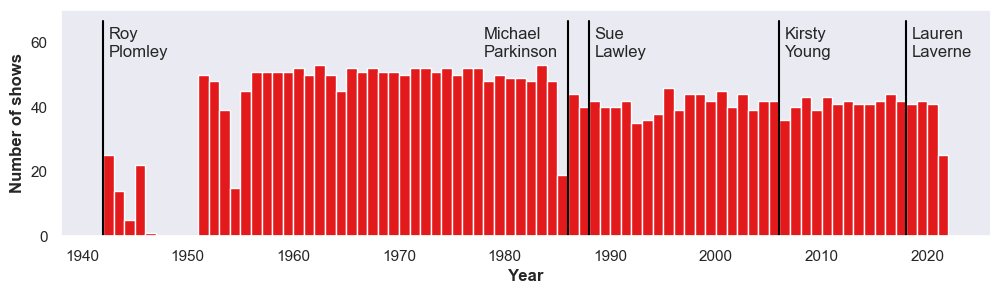

In [4]:
hosts = [
    ("Roy Plomley", "29/01/1942", "11/05/1985"),
    ("Michael Parkinson", "05/01/1986", "13/03/1988"),
    ("Sue Lawley", "27/03/1988", "27/08/2006"),
    ("Kirsty Young", "01/10/2006", "28/09/2018"),
    ("Lauren Laverne", "05/10/2018", None),
]

fig = plt.figure(figsize=(12, 3), dpi=100)

n_bins = castaways_df.year.max() - castaways_df.year.min() + 1
bins = np.linspace(castaways_df.year.min(), castaways_df.year.max() + 1, n_bins + 1)
plt.hist(castaways_df.year, bins=bins, color=sns.color_palette("Paired", 10)[5])

_, ymax = plt.ylim()
for host in hosts:
    year = pd.to_datetime(host[1], infer_datetime_format=True).year
    plt.plot([year, year], [0, ymax * 1.2], color="black", ls="solid")
    if host[0] == "Michael Parkinson":
        plt.annotate(host[0].replace(" ", "\n"), xy=(year - 8, ymax))
    else:
        plt.annotate(host[0].replace(" ", "\n"), xy=(year + 0.5, ymax))

plt.xlabel("Year", fontweight="bold")
plt.ylabel("Number of shows", fontweight="bold")
plt.grid(False)
plt.show()

Plotting the episodes, you can immediately see the long run of the programme, minus a small hiatus after WWII. This plot also illustrates the long period of time that Plomley served as host, which accounts for the majority of episodes.

# Castaways

## Plotting functions

In order to look at the castaways who have been on the show in more detail, lets define some functions. These will help us to aggregate episodes in the same year, and then plot summary metrics as a function of year.

In [5]:
# functions to help make stacked plots over time


def normalize_rows(df):
    df = df.div(df.sum(axis=1), axis=0)
    df = df.fillna(0)

    return df


def cumulative_columns(df):
    """
    Loop through columns and calculate running totals
    per row.
    """

    # for each column (except the first)
    for i, col in enumerate(df):
        if i == 0:
            continue

        # add the previous column to this column
        df[col] += df[df.columns[i - 1]]

    return df


def moving_average(df, n=3):
    df = df.rolling(window=n).mean()  # moving average
    df = df.dropna(how="all")  # drop lost columns

    return df


def make_timeplot(
    df, ymin=0, horiz_line_y=0, leg_title="", y_title="Fraction of Castaways"
):
    c = sns.color_palette("Paired", max(4, len(df.columns)))

    plt.figure(figsize=(10, 3), dpi=100)
    plt.gca().set_facecolor(c[0])
    xs = df.index

    for i, col in enumerate(reversed(df.columns)):
        plt.fill_between(
            xs, df[col], interpolate=False, color=c[i], label=col, alpha=1.0
        )

    if horiz_line_y > 0:
        plt.plot(
            plt.xlim(),
            [horiz_line_y, horiz_line_y],
            color="black",
            ls=((0, (10, 5))),
            lw=1.5,
        )

    plt.xlabel("Year", fontsize=10, fontweight="bold")
    plt.ylabel(y_title, fontsize=10, fontweight="bold")

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.xlim(df.index[0], df.index[-1])
    plt.ylim(ymin, 1)
    leg = plt.legend(
        loc="upper left",
        bbox_to_anchor=(1.01, 1.01),
        fontsize=10,
        facecolor="white",
        frameon=True,
        framealpha=1,
        edgecolor="white",
    )
    leg.set_title(
        leg_title, prop={"size": 10, "weight": "bold", "family": "sans-serif"}
    )
    leg._legend_box.align = "left"

    plt.show()

## Gender

Now we have these functions to make the plots we need, we can first take a look at the distribution of gender through time.

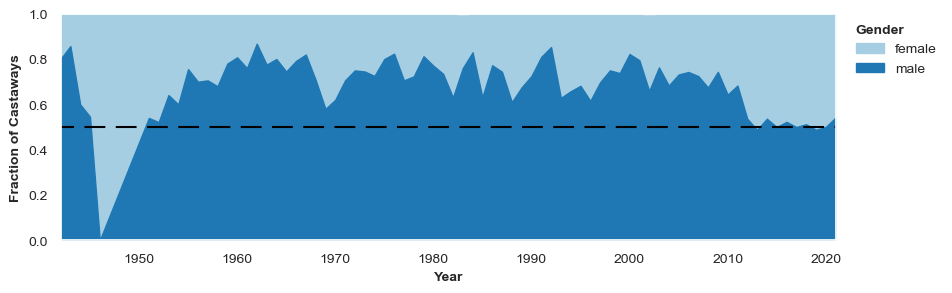

In [6]:
gender_df = pd.pivot_table(
    castaways_df, columns="gender", index="year", values="date", aggfunc="count"
)
gender_df = normalize_rows(gender_df)
gender_df = gender_df[["male", "female"]]
gender_df = cumulative_columns(gender_df)
make_timeplot(gender_df, horiz_line_y=0.5, leg_title="Gender")

Okay, there are a few things to notice here. The first is that, throughout the bulk of the show's long history, there have been significantly more male castaways than female. But the plot is very spikey, demonstrating that from year to year the gender ratio of castaways on the show fluctuates by an appreciable amount. Since we are interested in looking at trends over several years, and not differences between consecutive years, lets try smoothing this plot by using a [moving average](https://en.wikipedia.org/wiki/Moving_average) of 5 years.

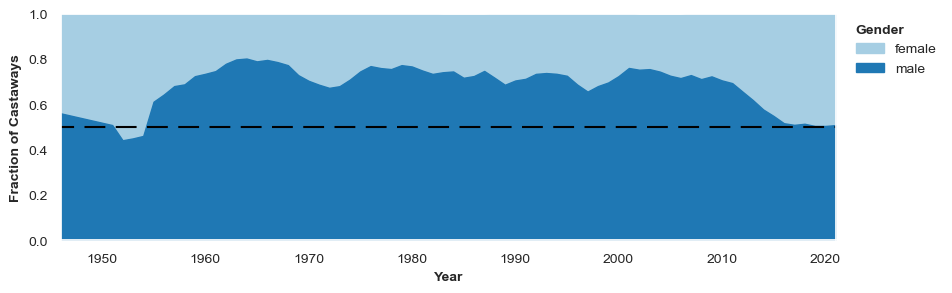

In [7]:
make_timeplot(moving_average(gender_df, n=5), horiz_line_y=0.5, leg_title="Gender")

The smoothed plot confirms the observation that the show has had significantly more males than females. 

Around 1950, it looks as though there was a much more equal split between men and women. However, this conclusion is drawn a bit hurriedly. If we look at the number of episodes per year around this time, we see that the show was actually off the air for several years around this period. There was also a year (1946), where only one episode aired, and the castaway was female (actress [Barbara Mullen](https://www.bbc.co.uk/programmes/p009y00q)). As we are giving each year equal visual weight with our plot, the show looks more balanced in terms of gender at it's inception than it was. 

From the beginning of the show, up until the early 2010s, there were about 3/4 male castaways and 1/4 female castaways. A little after 2010, we see a qualitative shift, and the split between males and females quickly becomes much more even. The suddenness of this change suggests it was a active decision taken by the producers of the show. The fact that this happened relatively recently is perhaps surprising.

In [8]:
print("Percentages of different genders, integrated over time")
round(castaways_df["gender"].value_counts(dropna=False) / len(castaways_df) * 100, 1)

Percentages of different genders, integrated over time


male                  68.6
female                29.7
NaN                    1.6
transgender female     0.1
Name: gender, dtype: float64

Finally, it's worth noting that since Wikipedia does not have information on every castaway, we are missing information on some castaways. In this case, we don't have a gender for 1.6% of castaways.

## Age

We might also wonder whether the age of castaways (at the time of them appearing on the show) has changed over time. For example, might recent guests on the show be younger to appeal to a younger demographic of listeners?

Using the date of birth of the castaway from Wikidata, and the broadcast date of the episode, we can calculate how old the castaways were when they were on the show.

In [9]:
# Calculate Age
cols_of_interest = ["name", "std_name", "gender", "date", "date_of_birth", "year"]
castaways_age_df = castaways_df[cols_of_interest].assign(
    age=lambda x: (
        (x["date"].dt.year - pd.to_datetime(castaways_df["date_of_birth"]).dt.year)
        - (x["date"].dt.month < pd.to_datetime(castaways_df["date_of_birth"]).dt.month)
    )
)
castaways_age_df.head(1)

,name,std_name,gender,date,date_of_birth,year,age
0,Vic Oliver,vic oliver,male,1942-01-29,1898-07-08,1942,43.0


In [10]:
# find oldest castaway(s)
castaways_age_df.loc[castaways_age_df["age"] == castaways_age_df["age"].max()]

,name,std_name,gender,date,date_of_birth,year,age
1455,Sir Robert Mayer,robert mayer,male,1979-06-05,1879-06-05,1979,100.0
2258,Kathleen Hale,kathleen hale,female,1998-06-05,1898-05-24,1998,100.0


In [11]:
# find youngest castaway(s)
castaways_age_df.loc[castaways_age_df["age"] == castaways_age_df["age"].min()]

,name,std_name,gender,date,date_of_birth,year,age
1024,Quentin Poole,quentin poole,male,1970-12-28,1957-01-01,1970,13.0


The youngest castaway was musician [Quentin Poole](https://www.bbc.co.uk/programmes/p009ndfl), who at the age of 13 appeared on the 1970 Christmas episode when he was the head chorister at King's College Cambridge. Businessman, philanthropist and patron of music [Sir Robert Mayer](https://www.bbc.co.uk/programmes/p009mxdk) appeared on the programme on his 100th birthday.

In [12]:
# Make a dataframe of all teenagers
teens = castaways_age_df[castaways_age_df["age"] < 20]
teens.head(10)

,name,std_name,gender,date,date_of_birth,year,age
84,Petula Clark,petula clark,female,1951-05-02,1932-11-15,1951,18.0
313,Janette Scott,janette scott,female,1956-12-24,1938-12-14,1956,18.0
736,Hayley Mills,hayley mills,female,1965-05-10,1946-04-18,1965,19.0
1024,Quentin Poole,quentin poole,male,1970-12-28,1957-01-01,1970,13.0


In [13]:
# and one of all those over 95 years old
older = castaways_age_df[castaways_age_df["age"] > 95]
older.head(10)

,name,std_name,gender,date,date_of_birth,year,age
1455,Sir Robert Mayer,robert mayer,male,1979-06-05,1879-06-05,1979,100.0
1497,Commissioner Catherine Bramwell-Booth,commissioner catherine bramwell-booth,female,1980-04-11,1883-07-20,1980,96.0
1712,George Abbott,george abbott,male,1984-09-07,1887-06-25,1984,97.0
1885,Athene Seyler,athene seyler,female,1989-03-19,1889-05-31,1989,99.0
1903,Gwen Ffrangcon-Davies,gwen ffrangcon-davies,female,1989-09-01,1891-01-25,1989,98.0
2258,Kathleen Hale,kathleen hale,female,1998-06-05,1898-05-24,1998,100.0
2889,Jeremy Hutchinson,jeremy hutchinson,male,2013-10-25,1915-03-28,2013,98.0
2961,Harry Rabinowitz,harry rabinowitz,male,2015-07-03,1916-03-26,2015,99.0


From the two dataframes, teens and older, we can see there have been 4 castaways under the age of 20, and 8 over the age of 95. 
There have been no teenaged castaways for over 51 years, and the last castaway over 95 was broadcast seven years ago.

In [14]:
# calculate average age of male and female castaways
av_age_m = castaways_age_df[castaways_age_df["gender"] == "male"]["age"].mean()
av_age_f = castaways_age_df[castaways_age_df["gender"] == "female"]["age"].mean()
print(
    f"The average age of the male castaways is {av_age_m:.1f} and the average age of the female castaways is {av_age_f:.1f}"
)

The average age of the male castaways is 53.5 and the average age of the female castaways is 53.7


A quick calculation shows that the average age for male and female castaways is very similar, around 53 and a half years old.

We now will segment the castaways by decade to explore trends in age over time.

In [15]:
# Add function to add median line to kde ridge plots


def kdeplot_med(data, **kwargs):

    data = data.dropna(subset=[kwargs["x"]])

    _ax = plt.gca()

    density = stats.gaussian_kde(data[kwargs["x"]].dropna())

    _, ymax = _ax.get_ybound()

    _ax.axvline(
        data[kwargs["x"]].median(),
        color=kwargs["color"],
        ymax=(density(data[kwargs["x"]].median())[0] / ymax),
    )
    _ax.annotate(
        int(data[kwargs["x"]].median()),
        (data[kwargs["x"]].median() + 1, density(data[kwargs["x"]].median())[0] * 0.65),
        xycoords="data",
        fontweight="bold",
    )

    return _ax

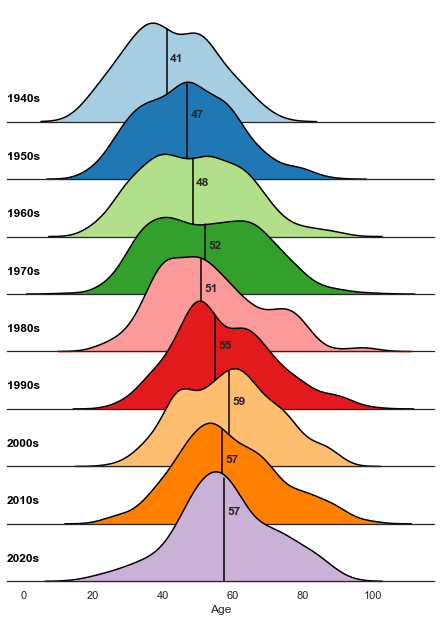

In [16]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(
    castaways_age_df.assign(decade=lambda x: (x["year"] // 10) * 10),
    palette="Paired",
    hue="decade",
    row="decade",
    aspect=7,
    height=1.0,
)
BW = 0.9
g.map_dataframe(
    sns.kdeplot,
    x="age",
    fill=True,
    alpha=1,
    bw_adjust=BW,
    clip_on=False,
)
g.map_dataframe(sns.kdeplot, x="age", color="black", bw_adjust=BW)
g.map_dataframe(
    kdeplot_med, x="age", fill=True, alpha=1, bw_adjust=BW, clip_on=False, color="black"
)


def label1(k, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label + "s",
        fontweight="bold",
        color="black",
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label1, "age")
g.set_ylabels("")
g.set_xlabels("Age")
g.fig.subplots_adjust(hspace=-0.5)
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)
plt.show()

Looking at the range of ages by decade, the plot above indicates that the castaways are aging over time: the media age has increased from the early 40s in the 1940s to late 50s in the 2020s. For comparison, the [median age of the British population](https://ourworldindata.org/grapher/median-age?tab=chart&country=~GBR) increased from 34.9 in 1950 to 40.2 in 2015.

A great example of how the guests (and audience?) are aging is castaway Sir Cliff Richard. The pop singer [first appeared](https://www.bbc.co.uk/programmes/p009y6z4) on the show at the age of 20 in 1960 (favourite song: Rock Around the Clock by Bill Haley and his Comets, book: The Swiss Family Robinson by Johann Wyss, luxury: guitar) and returned for the 2020 [Christmas epsiode](https://www.bbc.co.uk/programmes/m000qhg8) at the age of 80 (favourite song: It Is Well by Sheila Walsh featuring Cliff Richard, book: Wuthering Heights by Emily Brontë, luxury: a Gibson acoustic guitar).

In [17]:
castaways_df.query("std_name == 'cliff richard'")

,episode_ref,date,castaway_ref,name,std_name,gender,profession,country_of_citizenship,place_of_birth,country_of_birth,date_of_birth,favTrack,luxury,book,wiki_link,link,year
511,2654,1960-10-31,484,Cliff Richard,cliff richard,male,"['film actor', 'actor', 'performing artist', '...",United Kingdom,Lucknow,India,1940-10-14,Rock Around The Clock by Bill Haley and His Co...,Guitar,The Swiss Family Robinson - Johann Wyss,https://en.wikipedia.org/wiki/Cliff_Richard,https://www.bbc.co.uk/programmes/p009y6z4,1960
3190,3259,2020-12-20,484,Sir Cliff Richard,cliff richard,NaN,NaN,NaN,NaN,NaN,NaT,NaN,Wuthering Heights¬†by¬†Emily Bront√´,A Gibson¬†acoustic guitar,https://en.wikipedia.org/wiki/Sir_Cliff_Richard,https://www.bbc.co.uk/programmes/m000qhg8,2020


## Country of birth

From Wikipedia, we can also ask for information about the country of birth for the castaways on the show. For visual clarity, we have used the `pycountry` package to get the continent of each country, breaking the United Kingdom out into its own category due to the majority of castaways being born in the UK. This information is not always available, as reflected by the "other" category on the plot.

In [18]:
def get_continent(country):
    """
    Fuzzy search for Continent based on input country, treating GB separately
    """

    # first search for country
    try:
        code = pc.countries.search_fuzzy(country)[0].alpha_2
    except:
        code = ""

    if code == "":
        return "Unknown"

    if code == "GB":
        return "UK"

    # next get continent code from country code
    continent_code = pcc.country_alpha2_to_continent_code(code)

    return continent_code

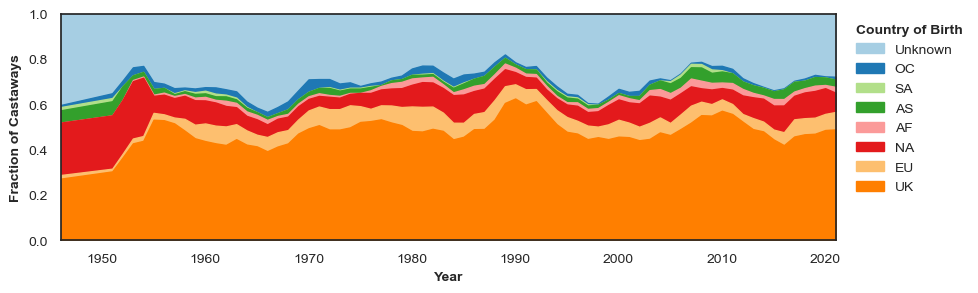

In [19]:
castaways_df["continent_of_birth"] = castaways_df.country_of_birth.apply(get_continent)
birth_df = pd.pivot_table(
    castaways_df,
    columns="continent_of_birth",
    index="year",
    values="date",
    aggfunc="count",
)

birth_df = normalize_rows(birth_df)
birth_df = birth_df[["UK", "EU", "NA", "AF", "AS", "SA", "OC", "Unknown"]]
birth_df = cumulative_columns(birth_df)

make_timeplot(moving_average(birth_df, n=5), ymin=0.0, leg_title="Country of Birth")

Looking as a function of time, there are no drastic changes in the country of birth of castaways on the show. The fraction of castaways who have this information missing seems to have been slightly reduced since the beginning of the show. This could reflect changes in the notability of guests, or perhaps the increasing prevalence of information on Wikipedia.

For a BBC radio programme, perhaps it isn't a surprise that most castaways are from the UK, with other English-speaking countries with cultural connections (Australia, USA) being very prominent. In fact, the large number of castaways from the USA from the start of the show might make sense in the context of castaway profession.

## Profession

We can also ask Wikipedia for information about professions that the castaways have, in order to get a better idea of which roles in society are reflected on the show.

We obtain from Wikipedia a list of professions of decreasing granularity for each castaway. As such, the data isn't all comparable without some initial work. For example, Vic Oliver is at the highest level of granularity an actor (as far as Wikipedia is concerned), but he is also a performing artist, an artist, and ultimately a professional.


In [20]:
castaways_df.std_name.iloc[0], castaways_df.profession.iloc[0]

('vic oliver', "['actor', 'performing artist', 'artist', 'professional']")

Since the number of possible professions that Wikipedia has knowledge of is too large to easily digest in a plot, we need to group similar professions into broad enough categories for visualisation. Do do this, we next define some functions to cluster professions, aiming to have the most granular profession for each castaway, while still maintaining a manageable number of possible categories. These functions are a little ad hoc, and rely on some parameters that have been manually selected to achieve sensible results. A more sophisticated approach could reduce the need for this.

In [21]:
def reduce(prof_list, common_professions):
    """
    Given a list of professions for a single castaway, try and return the most
    granular profession for this castaway if it is common enough.
    """

    # no options available, just take whatever profession is left
    if len(prof_list) == 1 or "professional" in prof_list[1]:
        return [prof_list[0]]

    # take the most granular profession if it is common
    for prof in prof_list:
        if prof in common_professions and prof != "professional":
            return [prof]

    # if none are common, restrict the set of professions to cluster
    else:
        return prof_list[1:]


def cluster_step(profession_lists, n=10):
    """
    At each step, take the n most common professions that appear globally,
    and attempt to match castaways to one of these professions.
    """

    # get the most common categories
    common_professions = pd.Series(
        [i for x in profession_lists for i in x]
    ).value_counts()[:n]

    # apply clustering
    out = [reduce(p, common_professions) for p in profession_lists]

    return out


def simplify_professions(profession_lists, n=25):
    """
    Run the clustering process.
    """

    # run clustering iteratively for ten steps
    for i in range(10):
        profession_lists = cluster_step(profession_lists)

    # clean
    professions = [p[0] for p in profession_lists]
    least_common = pd.Series(professions).value_counts(ascending=True)[:n]
    professions = [p if p not in least_common else "other" for p in professions]

    return professions

Now we have the clustering functions defined, we can define one additional function which does some preprocessing, runs the clustering, and makes a plot.

In [22]:
def get_profession_plot(df, n=20, window=10, leg_title=""):

    profession_df = df.copy()
    profession_df.loc[profession_df.profession == "[]", "profession"] = np.nan
    profession_df = profession_df.fillna({"profession": "['unknown']"})
    profession_df.profession = profession_df.profession.apply(
        lambda x: ast.literal_eval(x)
    )
    profession_df["profession"] = simplify_professions(profession_df["profession"], n=n)

    prof_df = pd.pivot_table(
        profession_df,
        columns="profession",
        index="year",
        values="date",
        aggfunc="count",
    )

    prof_df = prof_df[
        [c for c in prof_df.columns if c not in ["other", "unknown"]]
        + ["other", "unknown"]
    ]
    prof_df = normalize_rows(prof_df)
    prof_df = cumulative_columns(prof_df)

    make_timeplot(moving_average(prof_df, n=window), ymin=0.0, leg_title=leg_title)

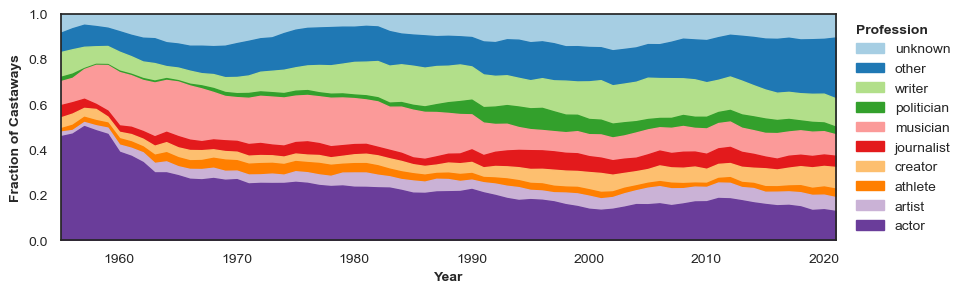

In [23]:
get_profession_plot(castaways_df, n=34, leg_title="Profession")

As you can see, the professions most frequently represented on Desert Island Discs are people who work in the media and creative industries – actors, artists, journalists, musicians and writers. This makes sense, as it is an entertainment programme with a foundation of music. But we were surprised not to see more representation from the many professions that are influential in British society - politicians, athletes, academics and people involved in business, health, and law are all very small percentages of castaways.

There are also clear trends visible over time. In the first half of the show's history actors and musicians made up the bulk of guests. In more recent years the proportion of castaways being grouped into the "other" category has increased, indicating an increase diversity in castaways' occupations.

# Discs

In the dataset we introduced in the beginning, we also grabbed information about the songs shared by each castaway. Based on Andrew's initial analysis, we know that classical music dominates the musical selections, and we want to dig a little deeper into the types of music chosen over time, as well what types of people choose different genres building on the analysis above.

## Genres

From Spotify, we can get a list of genres associated with the musical artist and additional info and analysis for each song (for example, danceability). It turns out Spotify has an overwhelming number of microgenres – see Glenn McDonald's [everynoise.com](https://everynoise.com) for a mind blowing micro-genre experience – and we need to do some work to get a small number of the most common and most easily recognised genres. We initial had hoped to algorithmically develop a series of meta-genres to use for analysis, but this proved beyond the scope of this data story.

To start, we can load the discs data, and the dataset pulled from Spotify API. These are then merged.

In [24]:
# load discs data
discs_df = pd.read_excel(
    hc_data_url, sheet_name="discs", parse_dates=["date"], index_col=0
)

# load spotify data
spotify_df = pd.read_excel(
    hc_data_url, sheet_name="spotify_data", parse_dates=["date"], index_col=0
)
spotify_df.genres_artist = spotify_df.genres_artist.apply(lambda x: ast.literal_eval(x))
spotify_df = spotify_df.dropna(subset=["track"])

# combine disks and spotify data
merged_df = pd.merge(
    discs_df,
    spotify_df,
    left_on=["track_name", "date"],
    right_on=["track_name_original", "date"],
    how="inner",
)

# extract year
merged_df["year"] = merged_df["date"].dt.year

Now the interesting part. After a bit of a manual look through the most common microgenres returned by Spotify, we came up with the following manual grouping.

In [25]:
meta_genres = {
    "pop": ["easy listening"],
    "rock": [],
    "folk": [
        "bothy",
        "celtic",
        "scottish",
        "bagpipe",
        "irish",
        "welsh",
        "bluegrass",
        "country",
    ],
    "jazz": [
        "blues",
        "british dance band",
        "big band",
        "ragtime",
        "boogie",
        "brass band",
    ],
    "classical": [
        "choral",
        "bolero",
        "opera",
        "operetta",
        "orchestral",
        "orchestra",
        "romantic era",
        "light music",
        "baroque",
    ],
    "vintage": [
        "adult standards",
        "music hall",
        "british comedy",
        "broadway",
        "cabaret",
        "tin pan alley",
    ],
    "world": [
        "italian",
        "chanson",
        "french",
        "bossa",
        "samba",
        "flamenco",
        "salsa",
        "latin",
        "african",
        "zither",
        "cuban rumba",
        "arpa paraguaya",
    ],
    "modern": [
        "disco",
        "soul",
        "r&b",
        "reggae",
        "ska",
        "hip hop",
        "rap",
        "electronic",
        "electronica",
        "house",
        "ambient",
        "downtempo",
        "garage",
        "synthesizer",
        "drum and bass",
    ],
    "spoken & soundtrack": [
        "soundtrack",
        "hollywood",
        "show tunes",
        "movie",
        "poetry",
        "comic",
        "reading",
        "comedy",
        "oratory",
    ],
}


def determine_genre(genre_list):
    """
    Given a list of genres for a particular song, return the first
    matched meta genre.
    """
    if genre_list == []:
        return ""
    for genre in genre_list:
        for meta_genre in meta_genres.keys():
            search_strings = [meta_genre] + meta_genres[meta_genre]
            if any([s in genre for s in search_strings]):
                return meta_genre
    return "other"

We can use the groups of genres defined above to turn the list of genres associated with each track into a single metagenre. Anything not captured in our very coarse categorisation goes into the "other" metagenre.

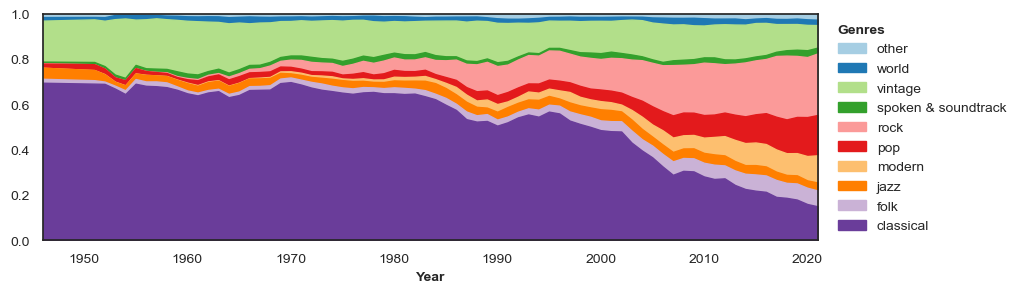

In [26]:
# get metagenre from the genre list
merged_df["genre"] = merged_df.genres_artist.apply(determine_genre)

# drop rows without any genre
merged_df = merged_df[merged_df["genre"] != ""].copy()

# make a timeplot
genre_df = pd.pivot_table(
    merged_df, columns="genre", index="year", values="date", aggfunc="count"
)
genre_df = genre_df[[c for c in genre_df.columns if c not in ["other"]] + ["other"]]
genre_df = normalize_rows(genre_df)
genre_df = cumulative_columns(genre_df)
make_timeplot(moving_average(genre_df, n=5), ymin=0.0, leg_title="Genres", y_title="")

The plot above clearly illustrates the shift away from classical music, which doesn't really start until Plomley's reign as host ends in the mid-1980s. This trend accelerated after 2000 and rock music now represents a larger proportion of dics than classical music.

The "vintage" category was the second largest genre for much of the programme. Including artists like Frank Sinatra, it captures the popular music of the 1950s and now reflects more retro tastes. The "modern" category combines a number of more recent genres, from disco and ska to hip-hop and rap. 

Next we see who were the most popular artists per year.  First we merge our castaway and disc datasets, in order to have all the available information in one single dataframe.

In [27]:
total_df = pd.merge(
    merged_df,
    castaways_df,
    left_on=["std_name", "date", "episode_ref_x", "castaway_ref"],
    right_on=["std_name", "date", "episode_ref", "castaway_ref"],
    how="inner",
)

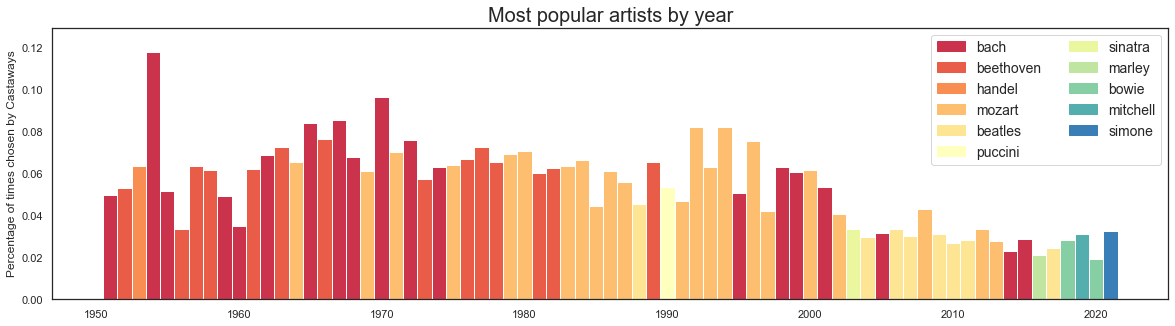

In [28]:
# choose only after 1950, before data looks weird given few entries and group by year
df1_grouped = total_df[total_df["year_x"] > 1949].groupby("year_x")

dates = []
levels = []
names = []

for group_name, df_group in df1_grouped:

    # year
    dates.append(group_name)

    # percentage of times it is chosen
    levels.append(
        df_group["std_artist"].value_counts()[:1].values[0]
        / df_group["std_artist"].shape[0]
    )

    # artist chosen (last name)
    names.append(df_group["std_artist"].value_counts()[:1].index[0].split(" ")[-1])


# associating names to colours and order them chronologically
names_cronological = list(dict.fromkeys(names))
c = sns.color_palette("Spectral", max(4, len(np.unique(names_cronological))))
colours = {g: c[i] for i, g in enumerate(names_cronological)}

# Create figure and bar plot
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title("Most popular artists by year", fontsize=20)

ax.bar(dates, levels, 1, color=[colours[x] for x in names])

labels = list(colours.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colours[x]) for x in names_cronological]
ax.legend(handles, labels, facecolor="white", ncol=2, fontsize=14)
ax.grid(False)

# remove y axis and spines
plt.ylabel("Percentage of times chosen by Castaways", fontsize=12)

ax.margins(y=0.1)
plt.show()

The most popular artist by year parallels the overall look at genres. Classical composers dominate until the early 2000s, with a classical grudge match between Bach, Beethoven and Mozart. Over the past two decades, The Beatles consistently top the charts, joined by Frank Sinatra, Bob Marley, David Bowie, Joni Mitchell, and Nina Simone.

# Castaways and discs

We now will combine information about people and the music that they chose to look for any trends. Before getting into a more sophisticated network analysis, we can look at the musical genres chosen by different castaway professions.

In [29]:
total_genpro_df = total_df[["profession", "genre"]].copy()
total_genpro_df.loc[total_genpro_df.profession == "[]", "profession"] = np.nan
total_genpro_df = total_genpro_df.dropna()

total_genpro_df.profession = total_genpro_df.profession.apply(
    lambda x: ast.literal_eval(x)
)
total_genpro_df["profession"] = simplify_professions(
    total_genpro_df["profession"], n=32
)
total_genpro_df = total_genpro_df.sort_values(
    ["profession", "genre"], ascending=[True, False]
)
# Move 'other' to be at the end.
other_profession = total_genpro_df["profession"] == "other"
total_genpro_df = pd.concat(
    (total_genpro_df[~other_profession], total_genpro_df[other_profession])
)
other_genre = total_genpro_df["genre"] == "other"
total_genpro_df = pd.concat(
    (total_genpro_df[other_genre], total_genpro_df[~other_genre])
)

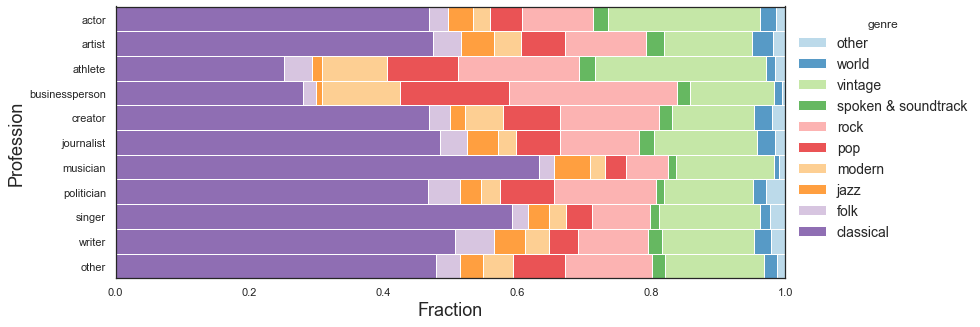

In [30]:
plt.figure(figsize=(12, 5))
g = sns.histplot(
    data=total_genpro_df, y="profession", hue="genre", multiple="fill", palette="Paired"
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), frameon=False, fontsize=14)
g.set_xlabel("Fraction", fontsize=18)
g.set_ylabel("Profession", fontsize=18)
plt.show()

Politicians have been accused of using focus groups to pick their discs, so we were curious about how they compared to other professions. The genre breakdown for politicians is broadly similar to the creative professions and other fields. Musicians and singers (including many which were classically trained) are more likely to pick classical music. For athletes and businesspeople, a larger proportion of genres are popular music (modern, pop, rock, vintage).

## Network analysis


An interesting way of looking at this data is to think of it as a network. You can have two kind of networks: one where the castaways are the nodes and they are connected by having chosen the same musical artist, and the other one is where the musical artists are the nodes and their connections are defined by how many castaways chose them together. 

A network analysis can give us an idea of castaway/artist similarity and popularity, as well as uncovering some non-trivial patterns (in the best of cases).

Let's start building a network for our castaways. We will use our castaway and disc merged dataset, in order to have all the available information in one single dataframe.

Some of our castaways have appeared in more than one episode. Let's check who:

In [31]:
# if the is a person with more than one episode keep indexes of the last episode only,
# given that our dataset is sorted we do this by only keeping the last entry
list_index = []
count_repeats = 0
for name in np.unique(total_df[["std_name"]]):

    castaway = total_df[total_df["std_name"] == name]

    dates = np.unique(castaway["date"].values)

    if len(dates) > 1:
        count_repeats = count_repeats + 1
        if len(dates) > 3:
            print(name, ":", [str(d)[:10] for d in dates])

    # saving the index of the latest episode avalaible for each cast away
    index = castaway[(castaway["date"] == dates[-1])].index.values

    list_index = [*list_index, *index]

print(
    count_repeats,
    " recurrent guests out of",
    len(np.unique(total_df[["castaway_ref"]])),
)

arthur askey : ['1942-04-02', '1955-04-21', '1968-12-23', '1980-12-26']
david attenborough : ['1957-05-06', '1979-03-13', '1998-12-27', '2012-02-03']
202  recurrent guests out of 2450


As you can see above, both David Attenborough and was Arthur Askey were invited to the show four times!

Having repeated guests in our dataset can be problematic for building the network, as these castaways will have more connections than the ones that have been invited only once. To resolve this problem, let's make sure we only have one episode per castaway, by selecting the most recent episode available.

This count of total and repeat castaways is a little less than at the top of this notebook. As we are using a dataframe that has been merged with other data sources (Wikpedia, Spotify) we have lost some castaways where there was missing information. This is discussed in more detail in the conclusions.

In [32]:
# select only one episode per cast away using the indexes stored above
df_network = total_df.iloc[list_index]
df_network.shape

(12857, 53)

## Castaway network

Let's now build the castaway network. For this we have written the function below: for each available pair of nodes (castaways in this case) it counts how many connections it has (common artists). This is typically called an edge list that defines a source and target (nodes), and it gives it a weight (edge). 

In [33]:
def build_network(df, nodes_variable, edges_variable):

    """Function that builds a newtork based on given nodes or edges that are
    columns names on the input dataframe"""

    # loop over all the unique values of the edges columns
    df_list = []
    for edge in np.unique(df[edges_variable].astype(str).values):

        # get the all the nodes that have that edge
        nodes = np.unique(
            df[df[edges_variable] == edge][nodes_variable].dropna().values
        )

        # get all combination of nodes existing for that edge
        # and save it to a list where source and
        # targes are the nodes conected by that edge
        if len(nodes) > 1:
            source, target = zip(*itertools.combinations(nodes, 2))

            df_net = pd.DataFrame()
            df_net["source"] = source
            df_net["target"] = target

            df_list.append(df_net)

        else:
            continue

    # turns list to a dataframe and aggregate repeated rows
    # (source and targets can appear several times)
    # weight is the number of times that appears
    network = pd.concat(df_list)
    network = network[network["source"] != network["target"]]
    df_network = (
        network.groupby(["source", "target"])
        .size()
        .reset_index(name="weight")
        .sort_values(by="weight", ascending=False)
    )

    return df_network

In [34]:
df_castaway_network = build_network(df_network, "std_name", "std_artist")

# most conected pair of people
df_castaway_network[:10]

,source,target,weight
209492,denis matthews,itzhak perlman,6
36398,andor foldes,hephzibah menuhin,6
297911,george cansdale,rowland emett,5
522899,vernon scannell,vladimir ashkenazy,5
209556,denis matthews,jeremy thorpe,5
36724,andor foldes,mitsuko uchida,5
209389,denis matthews,gerald moore,5
36108,andor foldes,catherine gaskin,5
285657,fred hoyle,vladimir ashkenazy,5
209425,denis matthews,hardy amies,5


To understand what the table above describes, we can look at the choices of the top two pairs, in which the castaways are connected by some of the usual suspects of classical music. Pianist [Denis Matthews (1967)](https://www.bbc.co.uk/programmes/p009y2gb) and violinist [Itzhak Perlman (1978)](https://www.bbc.co.uk/programmes/p009mysv) both went with Bach, Beethoven, Brahms, Elgar, Mozart and Schubert. [Hephzibah Menuhin (1958)](https://www.bbc.co.uk/programmes/p009y841) and [Andor Foldes (1959)](https://www.bbc.co.uk/programmes/p009y7h7) - both pianists - included Bach, Bartók, Beethoven, Brahms, Mozart and Schubert in their lists.

Now we can feed this data to a network library to build our network.

In [35]:
G = nx.from_pandas_edgelist(df_castaway_network, edge_attr=["weight"])
print(nx.info(G))

Graph with 2447 nodes and 523560 edges


Networks have interesting metrics that can help us understand our dataset better. For example, we have the node degree metric, that tells us the number of edges connected to a given node. In our case, the node degree of a castaway will tell us how popular or rare their taste in music is. 

Let's explore who have the highest and lowest node degrees in our network.

In [36]:
# castaways with more degrees (more artist in common with others)
node_degrees = G.degree()
degree_sequence = sorted([d for n, d in node_degrees], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sorted(node_degrees, key=lambda x: x[1], reverse=True)[:10]

[('denis matthews', 1345),
 ('vernon scannell', 1243),
 ('hardy amies', 1220),
 ('itzhak perlman', 1206),
 ('bernard levin', 1205),
 ('claudio abbado', 1205),
 ('jeremy thorpe', 1191),
 ('alan alda', 1184),
 ('john updike', 1170),
 ('c day lewis', 1168)]

In the top ten, we've got three writers, two musicians, a conductor, an actor, a politician, a designer, and a cartoonist/sculptor. Eight of them appeared on the show before 1990, and chose almost exclusively classical music. The two guests from the 1990s - [Alan Alda](https://www.bbc.co.uk/programmes/p0093yqy) and [John Updike](https://www.bbc.co.uk/programmes/p0093pc1) – chose music spanning classical, jazz, vintage and rock.

In [37]:
# castaways with less degrees (the ones that chose niche stuff)
sorted(node_degrees, key=lambda x: x[1])[:10]

[('joan turner', 1),
 ('jack hylton', 1),
 ('dustin hoffman', 1),
 ('jamie cullum', 2),
 ('fenella fielding', 3),
 ('kimberley motley', 4),
 ('m m kaye', 5),
 ('vittorio radice', 5),
 ('roberto alagna', 5),
 ('courtney pine', 5)]

Looking at the three castaways with the lowest node degrees, we've got actor [Dustin Hoffman (2012)](https://www.bbc.co.uk/programmes/b01p314n), jazz band leader [Jack Hylton (1942)](https://www.bbc.co.uk/programmes/p009y0n5), and comedian and singer [Joan Turner (1988)](https://www.bbc.co.uk/programmes/p009mfwq). Both Hylton and Turner chose their own songs, which might explain their position. For Hoffman, his ranking appears to be as a result of particularly esoteric tastes, picking lesser known artists from jazz, rockabilly and film soundtracks.

## Artists network

Let's now explore how a network where the nodes are the artists and edges are weighted by the number of castaways that chose them together.

In [38]:
# artist more likely to be chosen toguether
df_artists_network = build_network(df_network, "std_artist", "std_name")
df_artists_network[:10]

,source,target,weight
16590,ludwig van beethoven,wolfgang amadeus mozart,162
14441,johann sebastian bach,wolfgang amadeus mozart,161
14247,johann sebastian bach,ludwig van beethoven,148
10607,franz schubert,wolfgang amadeus mozart,84
10521,franz schubert,ludwig van beethoven,75
10491,franz schubert,johann sebastian bach,72
14568,johannes brahms,ludwig van beethoven,62
14651,johannes brahms,wolfgang amadeus mozart,62
14192,johann sebastian bach,johannes brahms,60
8276,edward elgar,ludwig van beethoven,51


This list comes as no surprise, as we've got another "who's who" of classical music. In fact, the first nine are simply the various possible combinations of Bach, Beethoven, Brahms, Mozart and Schubert.

In [39]:
df_artists_network[-10:-1]

,source,target,weight
6899,della reese,johannes brahms,1
6900,della reese,peggy lee,1
6901,della reese,the beatles,1
6902,della reese,the modern jazz quartet,1
6903,denim,irma thomas,1
6904,denim,pixies,1
6905,denim,radiohead,1
6906,denim,the beatles,1
6907,denis king,neil diamond,1


This list of the bottom ten is less illuminating. Moving down the long tail of more obscure musical artists, we expect there will be lots of pairings that only happen once. For example, in this list is the lesser known Birmingham indie rock band Denim, which was chosen by [Charlie Brooker (2018)](https://www.bbc.co.uk/programmes/b09kx840), the satirist and creator of Black Mirror. His unique musical tastes were captured in the [BBC website summary](https://www.bbc.co.uk/programmes/articles/4gmjmCJvY1dSkLD6rngW06n/11-things-we-learned-from-charlie-brooker-s-desert-island-discs) of the episode:



> And for his final track, he selects The New Potatoes by Denim, a “wilfully ridiculous”, high-pitched electronic song that Charlie’s children find as funny as he does. It’s also the disc he would keep over all the others: “There is something darkly amusing about the thought of being stranded there [on the desert island] and the only form of music that you have is that.”

Denim appearing on Desert Island Discs this one time was worthy of including on their somewhat slim [Wikipedia entry](https://en.wikipedia.org/wiki/Denim_(band)), so it would be surprising to see them with many more pairings. Also, the reason there are only four pairings for Denin is that the other three picks by Brooker were so random that they weren't found on Spotify (including a song from the children's programme the Magic Roundabout and the Gameboy theme for Robocop). 

Now we can feed this data to a network library to build our network.

In [40]:
G_artists = nx.from_pandas_edgelist(df_artists_network, edge_attr=["weight"])
print(nx.info(G_artists))

Graph with 2088 nodes and 19717 edges


Let's take a look at the the node degree of our metric.

In [41]:
# get the artist that get more chosen with others
node_degrees = G_artists.degree()
degree_sequence = sorted([d for n, d in node_degrees], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())


In [42]:
def artist_bar_plot(artist_names,artist_centrality,genres_central,genre_order, title,ylabel):
    
    """Function to make a bar plot of artists based on a metric (node degree or centrality) """


    # Create figure and bar plot
    fig, ax = plt.subplots(figsize=(24, 6))
    ax.set_title(title, fontsize=20)

    c = sns.color_palette("Spectral", max(4, len(np.unique(genre_order))))
    colours = {g: c[i] for i, g in enumerate(genre_order)}

    ax.bar([a.split(" ")[-1] for  a in artist_names], artist_centrality, 1, color=[colours[x] for x in genres_central])

    labels = list(colours.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=colours[x]) for x in genre_order]
    ax.legend(handles, labels, facecolor="white", fontsize=14)

    # remove y axis and spines
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ha='right', rotation=55, fontsize=14)

    ax.margins(y=0.1)
    plt.show()

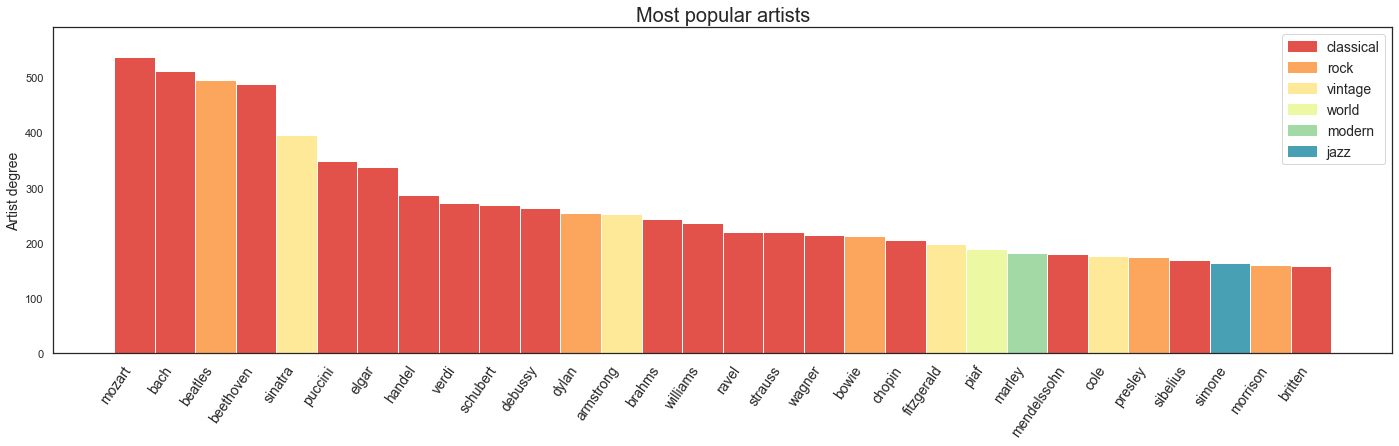

In [43]:
# get info out of dictionary
artist_dictionary = sorted(node_degrees, key=lambda x: x[1], reverse=True)[:30]

artist_names = [artist_dictionary[i][0] for i in range(0,len(artist_dictionary))]
artist_degree = [artist_dictionary[i][1] for i in range(0,len(artist_dictionary))]

# get genres for the artists and
genres_central = [total_df[total_df['std_artist']==artist]['genre'].iloc[0] for artist in artist_names]
    
genre_order = list(dict.fromkeys(genres_central))

artist_bar_plot(artist_names,artist_degree,genres_central,genre_order,"Most popular artists","Artist degree")

Looking at the artists with the highest node degrees: in addition to some familiar classical composers, we've got the Beatles (the most popular artists for much of the past two decades) and Frank Sinatra (the king of our vintage category).

Now we can look at the artists with less node degree, or the ones less chosen in our dataset.

In [44]:
sorted(node_degrees, key=lambda x: x[1])[:10]

[('gerard philipe', 1),
 ('lisa kirk', 1),
 ('josef suk', 1),
 ('teddy wilson', 1),
 ('nellie lutcher', 1),
 ('black dyke band', 1),
 ('arthur askey', 1),
 ('morgana king', 1),
 ('iarla o lionaird', 2),
 ('shankar mahadevan', 2)]

With the lowest node degrees, one performer that is worthy of note is Arthur Askey, an actor/comedian who appeared as a castaway on the show four times. On two of those appearances, he picked his own comedy routines from the films The Proposal and Band Waggon. Two other castaways included his musical comedy – actress [Pat Kirkwood](https://www.bbc.co.uk/programmes/p009y0n8) picked his playful song Worm in 1942 and actor [John Mills](https://www.bbc.co.uk/programmes/p00949y8) picked his WWII parody Adolf in 2000 – but that wasn't enough to increase his node degrees above 1.

Another interesting network analysis metric is node centrality, which assigns numbers or rankings to nodes within a graph corresponding to their network position. Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. We can investigate in our case which artists are the more central of our network. 

In [45]:
# the more "central artists" (interesting results!)

bet_cen = nx.betweenness_centrality(G_artists)


In [46]:
def get_top_keys(dictionary, top): 
    sorted_list = sorted(dictionary.items(), key=lambda item: item[1],reverse=True) 
    return sorted_list[:top]
    
# top ten more central artists
top_bet_cen = get_top_keys(bet_cen, 10)

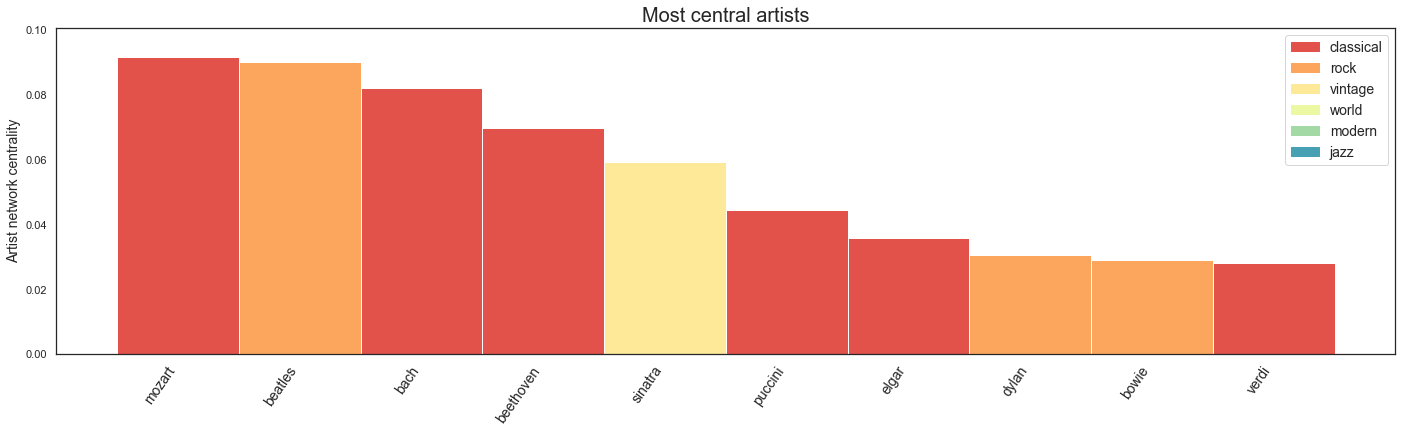

In [47]:
# get info out of dictionary
artist_dictionary = top_bet_cen

artist_names = [artist_dictionary[i][0] for i in range(0,len(artist_dictionary))]
artist_centrality = [artist_dictionary[i][1] for i in range(0,len(artist_dictionary))]

# get genres for the artists and
genres_central = [total_df[total_df['std_artist']==artist]['genre'].iloc[0] for artist in artist_names]
    
artist_bar_plot(artist_names,artist_centrality,genres_central,genre_order,"Most central artists","Artist network centrality")


In terms of betweenness, Mozart tops the classical composers, the Beatles come second, and Sinatra, Dylan and Bowie make the top ten.

The network analysis we have presented in this story is a very simple and naive one, a lot more could be explored using these kinds of techniques. For example, we could use community detection algorithms to explore the network structure and group artists or castaways together, also we could look at the time evolution of the networks to better understand how the cultural landscape of the UK has changed in the last 80 years. We invite the reader to investigate these ideas further!

# Discussion

In this data story, we've been looking at some of the trends of people and music on Desert Island Discs. As a mainstay of the BBC Radio schedule, it likely will continue for many decades to come, and this analysis could be continued at future milestones.

In this data story, we've identified a number of trends:
- Male castaways greatly outnumber female castaways, with the shift to a more representative gender balance about 10 years ago.
- The age of castaways has increased over time, with a clear trend decade by decade.
- The majority of castaways were born in the UK, but guests born in North America were a substantial percentage of early guests.
- In the early days of the programme, about half of the castaways were actors; while that percentage has decreased over time, the primary professions continue to be in the creative industries.
- The genres of music chosen on the show have evolved substantially over time, with classical music dominant until the mid-1980s, but current choices spread across a much wider range of genres.
- When looking at genres chosen by different professions, athletes and bussinesspeople appear to have more popular tastes.
- The network analysis reveals interesting connections between castaways and musical artists, with centrality reflecting the most popular, timeless music and artists, across multiple genres.

After discovering the Desert Island Discs dataset, and some exploratory analysis, this project grew into a fairly long data story. To keep things focused, there are elements of this process that we mention but don't go into much detail about, and more complicated analysis for which we found a workable shortcut. Future data stories could pick up on a few of these threads, for example data scraping from Wikipedia. Spotify also provides a data for each song that we didn't use, like danceability, and, as noted above, we could also algorithmically create the metagenres from the microgenres.

It's worth mentioning again that the data we used was incomplete. Wikipedia did not have complete information about all castaways, and we didn't always find matches for songs on Spotify. As examples, we were missing information about gender for around 1.5% of castaways, and we were missing profession information for around 10%. While this best-effort attempt limits our analysis somewhat, it is unlikely to substantially change our main findings.

## Invited back to the island

As a listener, each Friday and Sunday morning we are invited back to the island to hear someone's life story through music. But there are some very special guests who are invited back more than once. We close this story by looking at environmentalist and broadcaster David Attenborough's four episodes.

As a fresh 30-year-old TV presenter for his first appearance with Roy Plomley ([06/05/1957](https://www.bbc.co.uk/programmes/p009y8xh)), his first disc was Trouble in Mind by Northern Irish blues singer Ottilie Patterson and Chris Barber Jazz Band. When he returned at the age of 52 ([10/03/1979](https://www.bbc.co.uk/programmes/p009mxny)), he requested to take the book Shifts and Expedients of Camp Life by William Barry Lord to the island, which he consistently requested for his following two appearances. Sue Lawley welcomed back a 72-year-old Attenborough ([25/12/1998](https://www.bbc.co.uk/programmes/p00942qy)) who asked for the luxury of a guitar, having previously taken a piano and binoculars to the island. And finally, for the [70th Anniversary Episode (29/01/2012)](https://www.bbc.co.uk/programmes/b01b8yy0), Kirsty Young invited him back again, now 85, where the track he saved from the waves was the 3rd of Johann Sebastian Bach's Goldberg Variations. 

With any luck, Lauren Laverne will invite Sir David back again soon, at which point he will have the record for the most episodes all to himself. As he reflects once more on his life and favourite songs, perhaps he will talk about his evolution into a trusted voice on climate action. Hopefully, the rising seas of climate change don't threaten this island haven of music and autobiography.